In [63]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date
from datetime import datetime

## Data cleaning

In [76]:
data = pd.read_csv("http://theta.edu.pl/wp-content/uploads/2020/01/Aids2.csv", sep = ';')
data.head()

,sex,diag,death,status,age,Unnamed: 5
0,M,1929-11-08,1930-05-03,D,35,NaN
1,M,1930-03-12,1930-05-18,D,53,NaN
2,M,1926-02-23,1927-05-01,D,42,NaN
3,M,1926-03-21,1926-06-06,D,44,NaN
4,M,1927-06-02,1928-03-03,D,39,NaN


In [77]:
data = data.drop(columns = ['Unnamed: 5'])

In [78]:
def to_date(row):
  row = datetime.strptime(row,'%Y-%m-%d')
  return row
time = lambda x: x.death - x.diag
sex = lambda x: 1 if x.sex == 'M' else 0
status = lambda x: 1 if x.status == 'D' else 0
def time_days(row):
  row = row.days
  return row

Sex

1 - M

0 - F

Status

1 - Dead - D

0 - Live - A

In [79]:
data.death = data.death.apply(to_date)
data.diag = data.diag.apply(to_date)
data['time'] = data.apply(time, axis=1)
data['sex'] = data.apply(sex, axis=1)
data['status'] = data.apply(status, axis=1)
data['time'] = data['time'].apply(time_days)

In [80]:
data.head()

,sex,diag,death,status,age,time
0,1,1929-11-08,1930-05-03,1,35,176
1,1,1930-03-12,1930-05-18,1,53,67
2,1,1926-02-23,1927-05-01,1,42,432
3,1,1926-03-21,1926-06-06,1,44,77
4,1,1927-06-02,1928-03-03,1,39,275


In [81]:
data.describe()

,sex,status,age,time
count,2843.000000,2843.000000,2843.000000,2843.000000
mean,0.968695,0.619416,37.409075,405.937390
std,0.174171,0.485616,10.063263,363.926581
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,30.000000,128.000000
50%,1.000000,1.000000,37.000000,320.000000
75%,1.000000,1.000000,43.000000,583.000000
max,1.000000,1.000000,82.000000,2470.000000


## Survival Analysis

In [70]:
%pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Filtering data to get only 2 years (max 730 days) of thearpy

In [82]:
data['time2'] = data['time']
data['time2'][data['time2'] > 730] = 730
data['status2'] = data['status']
data['status2'][(data['time'] > 730) & (data['status'] == 1)] = 0
data

<ipython-input-82-b86e6f93436f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time2'][data['time2'] > 730] = 730
<ipython-input-82-b86e6f93436f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['status2'][(data['time'] > 730) & (data['status'] == 1)] = 0


,sex,diag,death,status,age,time,time2,status2
0,1,1929-11-08,1930-05-03,1,35,176,176,1
1,1,1930-03-12,1930-05-18,1,53,67,67,1
2,1,1926-02-23,1927-05-01,1,42,432,432,1
3,1,1926-03-21,1926-06-06,1,44,77,77,1
4,1,1927-06-02,1928-03-03,1,39,275,275,1
...,...,...,...,...,...,...,...,...
2838,1,1931-06-01,1931-06-30,0,46,29,29,0
2839,0,1931-04-07,1931-06-30,0,34,84,84,0
2840,1,1931-06-22,1931-06-30,0,49,8,8,0
2841,1,1931-05-17,1931-06-30,0,55,44,44,0


## Kaplan-Meier for 2nd year


In [83]:
import lifelines
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

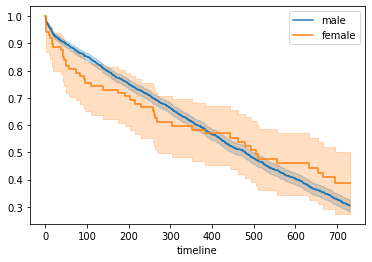

In [47]:
male = (data["sex"]==1)
female = (data["sex"]==0)

ax = plt.subplot(111)
kmf = KaplanMeierFitter()
kmf.fit(data[male]["time2"],data[male]["status2"],label="male")
kmf.plot_survival_function(ax=ax)

kmf.fit(data[female]["time2"],data[female]["status2"],label="female")
kmf.plot_survival_function(ax=ax)

plt.show()

## Logrank test

H0: Male and Female patients have the same survival curves

H1: Male and Female patients have different survival curves

In [49]:
from lifelines.statistics import logrank_test
logrank = logrank_test(data[male]["time2"], data[female]["time2"], data[male]["status2"], data[female]["status2"])
logrank.p_value

0.5946427341149176

H0: Male and Female patients have the same survival curves

## Weibul distribution

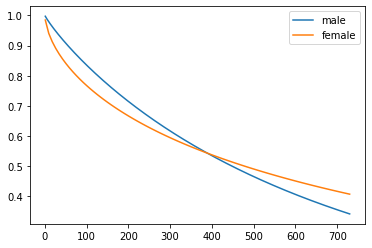

In [54]:
from lifelines import WeibullFitter
wb = WeibullFitter()
ax = plt.subplot(111)
wb.fit(data[male]["time2"],data[male]["status2"],label="male")
wb.survival_function_.plot(ax=ax)
wb.fit(data[female]["time2"],data[female]["status2"],label="female")
wb.survival_function_.plot(ax=ax)
plt.show()

In [55]:
print(wb.lambda_, wb.rho_)
print(wb.predict(20))

870.5870888639881 0.6142470950650616
0.906206678072434


## Comparison

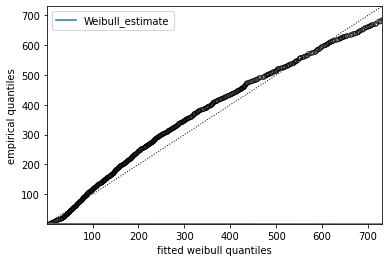

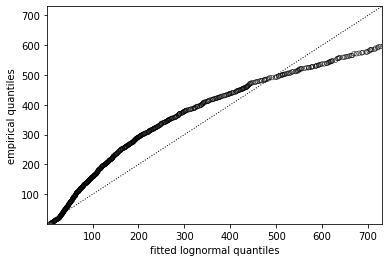

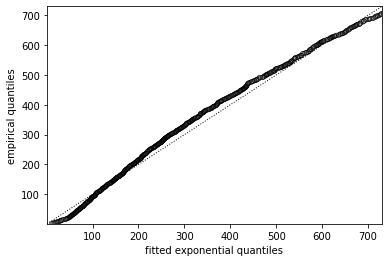

In [57]:
from lifelines.plotting import qq_plot 
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter
for model in [WeibullFitter(),
              LogNormalFitter(),
              ExponentialFitter()]:
  model.fit(data["time2"],data["status2"])
  model.plot_survival_function(ax = ax)
  qq_plot(model)
  plt.show()

The best qqplot has the Exponential distribution

In [58]:
wb = WeibullFitter().fit(data["time"],data["status"])
exp = ExponentialFitter().fit(data["time"],data["status"])
log_n = LogNormalFitter().fit(data["time"],data["status"])

print(wb.AIC_, exp.AIC_, log_n.AIC_)

26334.99075850715 26364.793180007837 26816.853987007118


The best AIC has the Weibull distribution

## Cox

In [84]:
data2 = data.drop(columns = ['diag', 'death', 'time', 'status'])
data1 = data.drop(columns = ['diag', 'death', 'time2', 'status2'])

In [85]:
from lifelines import CoxPHFitter
coxph = CoxPHFitter()
coxph.fit(df=data2, duration_col="time2", event_col="status2")
coxph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,0.060917,1.062810,0.149712,-0.232513,0.354346,0.792540,1.425248,0.0,0.406892,6.840870e-01,0.547748
age,0.017569,1.017724,0.002617,0.012439,0.022698,1.012517,1.022957,0.0,6.713316,1.902502e-11,35.613311


In [86]:
coxph.check_assumptions(data2, p_value_threshold=0.05)
#coxph.predict_median(X, conditional_after)
#coxph.predict_survival_function(X, conditional_after)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2843 total observations, 1294 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic      p  -log2(p)
age km             18.37 <0.005     15.75
    rank           17.13 <0.005     14.80
sex km              5.43   0.02      5.66
    rank            5.86   0.02      6.01



1. Variable 'sex' failed the non-proportional test: p-value is 0.0155.

   Advice: with so few unique values (only 2), you can include `strata=['sex', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'age' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lates

[]

In [87]:
coxph = CoxPHFitter()
coxph.fit(df=data1, duration_col="time", event_col="status")
coxph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,0.104277,1.109908,0.139598,-0.169329,0.377884,0.844231,1.459194,0.0,0.746984,4.550734e-01,1.135829
age,0.015087,1.015201,0.002457,0.010272,0.019902,1.010325,1.020102,0.0,6.140792,8.211122e-10,30.181702


In [88]:
coxph.check_assumptions(data1, p_value_threshold=0.05)
#coxph.predict_median(X, conditional_after)
#coxph.predict_survival_function(X, conditional_after)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2843 total observations, 1082 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic      p  -log2(p)
age km             25.91 <0.005     21.42
    rank           25.21 <0.005     20.89
sex km              5.47   0.02      5.69
    rank            6.21   0.01      6.30



1. Variable 'sex' failed the non-proportional test: p-value is 0.0127.

   Advice: with so few unique values (only 2), you can include `strata=['sex', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'age' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lates

[]

There is no significant difference in influence of sex and age on the status of patient between 2 and 5 years